In [45]:
import os,glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
import sys
import copy
import time
import re
from pandas import ExcelFile
import impnb
import Data_processing as dp
from scipy.stats import kurtosis
lib_path='/cndd/hop006/Github/'
excel_path=lib_path+'RewardReversalPorject/Data/UH2 Probabilistic Reversal Learning EEG.xlsx'
UH2_excel=pd.read_excel(excel_path,sheetname='Rat 30')
sys.path.append('/cndd/hop006/Github/RewardReversalPorject')
# from ToyQ2 import *


data_path='/cndd/emukamel/UH2_DerAvakian/PRL_analysis/Data'
output_path='/cndd/hop006/Data/epoched_eeg/'
behavior_log_path='/cndd/hop006/Github/RewardReversalPorject/BehaviorLog/'
git_data='/cndd/hop006/Github/RewardReversalPorject/Data/epoched_eeg'
files=glob.glob(os.path.join(data_path,'*'))
ERP_plot_path='/cndd/hop006/Github/RewardReversalPorject/Plots/ERP/'

# Getting just one rat
## saved rat 29, 18, 23, 30 as pickle

In [16]:
def get_ephys(date,rat_num):
    for i in files:
        fn=i.split('/')[-1].split()
        for j in fn:
            if j.split('_')[0]==str(date):
                if j.split('_')[1]=='Rat'+str(rat_num):
                    return scipy.io.loadmat(i)
    print('doesnt exist')
    return

def rat_summary(rat): # takes a single rat's data as a pd.Series object
    tvecs,signals,low_tones,high_tones,tars,off_tars=[],[],[],[],[],[]
    low_tone=np.round(rat['ttl'][0])
    high_tone=np.round(rat['ttl'][1])
    tar=np.round(rat['ttl'][3])
    off_tar=np.round(rat['ttl'][2])
    tvec=rat['tvec'][0]
    adc='empty' if rat['adc'].size==0 else rat['adc'][0]
    lfp='empty' if (rat['lfp'].size==0 or sum(sum(rat['lfp']))==0) else rat['lfp']
    eeg='empty' if (rat['eeg'].size==0 or sum(sum(rat['eeg']))==0) else rat['eeg']
    
    signal=lfp if lfp!='empty' else eeg
    signal=np.array(signal)
    
    return np.array(tvec),np.array(signal),np.array(low_tone),np.array(high_tone),np.array(tar),np.array(off_tar)

In [17]:
# rat23=get_ephys(20180525,23)
# tvec,signal,low_tone,high_tone,tar,off_tar=rat_summary(rat23)

check ttl, trigger on the tone, four types of erp trigger on the tone for teh auditory LFP

# Concat all the tvecs, remove artifact 
## eam live load eeg data 3times the inter quartile range as threshold 20180525 rat 23
# rat 9 aud erp

# Note on the data:
## low_tone is 3, high_tone is 4, on_target is 1, off_target is 2

In [18]:
def get_behavior(rat,eeg_length,reward_tone,plot=False): # each interval is around 0.002
    out=[]
    tvec,signal,low_tone,high_tone,tar,off_tar=rat_summary(rat)
    action_log=[]
    reward_log=[]
    HO_epoch,HOf_epoch,LO_epoch,LOf_epoch,TO_epoch,TOf_epoch,OO_epoch,OOf_epoch=[],[],[],[],[],[],[],[]
    pcount=1
    if plot:
        ax = plt.subplot(1,1,1)
        p1, = ax.plot(low_tone*3, label="low_tone")
        p2, = ax.plot(high_tone*4, label="high_tone")
        p3, = ax.plot(tar, label="targets")
        p4, = ax.plot(off_tar*2,label='off_targets')
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1])
    
    ttl=np.vstack((low_tone,high_tone,tar,off_tar))
    print(ttl.shape)
    shift0lead=np.hstack((np.zeros((ttl.shape[0],1)),ttl))
    shift0last=np.hstack((ttl,np.zeros((ttl.shape[0],1))))
    shiftdiff=shift0last-shift0lead
    assert((shiftdiff[:,0]==ttl[:,0]).all()) # assumption checks
    assert((ttl[:,-1]==0-shiftdiff[:,-1]).all())
    shiftdiff[:,0]=0 # The first one is always 1 so it's not informative
    # plt.plot(shiftdiff[3,580000:600000])
    # plt.plot(ttl[3][((shiftdiff[3][:-1])==-1)])
    # sum((shiftdiff[3][:-1])==-1),sum((shiftdiff[3][:-1])==1)
    
    high_tone_onset=(shiftdiff[1][:-1])==-1
    high_tone_offset=(shiftdiff[1][:-1])==1
    low_tone_onset=(shiftdiff[0][:-1])==-1
    low_tone_offset=(shiftdiff[0][:-1])==1
    tar_onset=(shiftdiff[2][:-1])==-1
    tar_offset=(shiftdiff[2][:-1])==1
    off_tar_onset=(shiftdiff[3][:-1])==-1
    off_tar_offset=(shiftdiff[3][:-1])==1
            
    zero_temp=np.zeros(tvec.shape)
    zero_temp[high_tone_onset]=4
    zero_temp[low_tone_onset]=3
    RE_epoch=[]
#     zero_temp[high_offset]=-1
#     zero_temp[low_offset]=-2
    
    # epoch by onset of tone here:
    for re in np.nonzero(zero_temp)[0]:
        RE_epoch.append(copy.deepcopy(signal[:,re-100:re+eeg_length]))
    for ho in np.nonzero(high_tone_onset)[0]:
        HO_epoch.append(copy.deepcopy(signal[:,ho-100:ho+eeg_length]))
    for hof in np.nonzero(high_tone_offset)[0]:
        HOf_epoch.append(signal[:,hof-100:hof+eeg_length])
    for lo in np.nonzero(low_tone_onset)[0]:
        LO_epoch.append(signal[:,lo-100:lo+eeg_length])
    for lof in np.nonzero(low_tone_offset)[0]:
        LOf_epoch.append(signal[:,lof-100:lof+eeg_length])
    for to in np.nonzero(tar_onset)[0]:
        TO_epoch.append(signal[:,ho-100:ho+eeg_length])
    for tof in np.nonzero(tar_offset)[0]:
        TOf_epoch.append(signal[:,tof-100:tof+eeg_length])
    for oo in np.nonzero(off_tar_onset)[0]:
        OO_epoch.append(signal[:,ho-100:ho+eeg_length])
    for oof in np.nonzero(off_tar_offset)[0]:
        OOf_epoch.append(signal[:,oof-100:oof+eeg_length])
        
    dicval=[HO_epoch,HOf_epoch,LO_epoch,LOf_epoch,TO_epoch,TOf_epoch,OO_epoch,OOf_epoch,RE_epoch]
    dickey=['HO_epoch','HOf_epoch','LO_epoch','LOf_epoch','TO_epoch','TOf_epoch','OO_epoch','OOf_epoch','RE_epoch']
    epoched_eeg=dict(zip(dickey,dicval))
    
    zero_temp[tar_onset]=1
    zero_temp[off_tar_onset]=2
    
    log=zero_temp[np.nonzero(zero_temp)]
    action_log+=(log[log<3].tolist())
    reward_log+=(log[log>2].tolist())


#         if bool(list(reward_loss_onset)):
#             print(log)

    if reward_tone.split()[0]=='Low': # not sure what's going here when it's low tone
        reward_log=np.array(reward_log)-3 # it seems like ttl is mislabeled or something
    elif reward_tone.split()[0]=='High':
        reward_log=np.array(reward_log)-3
    else:
        print('error')
    reward_log=np.array(reward_log)
    action_log=np.array(action_log)
    return action_log,reward_log,epoched_eeg

def eeg_by_index(rat_df,index,eeg_length=300): # index is a np array of the same shape as action_log
    action_log,reward_log,epoched_eeg=get_behavior(rat_df,eeg_length=300,plot=False)
    return np.array(epoched_eeg)[index]

def eeg_by_channel(epoches,chan):
    out=[]
    for i in epoches:
        out.append(i[chan])
    return np.array(out)

def eeg_by_label(epoched_eeg,chan,actions,rewards,action_label,reward_label):
    chan_eeg=eeg_by_channel(epoched_eeg['RE_epoch'],chan)
    out=[]
    for i,x in enumerate(zip(action_log,reward_log)):
        if x==(action_label,reward_label):
            out.append(chan_eeg[i])
    return np.array(out)

## Note: epoched_eeg is now a dictionary with keys:
'HO_epoch','HOf_epoch','LO_epoch','LOf_epoch','TO_epoch','TOf_epoch','OO_epoch','OOf_epoch'
## that values which is the epoched eeg

# EEG processing
## Removing artifact

In [19]:
from scipy.signal import butter, sosfiltfilt, sosfreqz
from scipy.fftpack import fft, fftfreq, fftshift
# Credit for these functions goes to 'WarrenWeckesser'
# https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html

def mask_by_abs(eeg_in,zero_fill=False): # need to specify eeg channel here
    eeg=copy.deepcopy(eeg_in)
    std=np.std(eeg)
    m=np.mean(eeg)
#     artifact=(np.abs((eeg-m)/std))>3
    artifact=np.abs(eeg)>1500
    arti_onset=np.where(artifact==1)[0]
    for i in arti_onset:
        eeg[i-100:i+100]=np.nan
    return eeg

def mask_by_kurtosis(eeg_in,zero_fill=False):
    eeg=copy.deepcopy(eeg_in)
    pass

def butter_bandpass(lowcut, highcut, fs, order = 2):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog = False, btype = 'band', output = 'sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order = 2):
        sos = butter_bandpass(lowcut, highcut, fs, order = order)
        y = sosfiltfilt(sos, data)
        return y
    
fs = 500.0     # 200 Hz sampling rate
low_cut  = 0.1; # EDIT THIS VARIABLE
high_cut = 30.0; # EDIT THIS VARIABLE
lowcut = 0.1   # 0.1 Hz is the lowest frequency we will pass
highcut = 30.0 # 30  Hz is the highest frequency we will pass.
order = 2;

def plot_average(eeg,fil=False,lowcut=None,highcut=None):
    fs=500.0
    order=2
    dt=1/fs
    tvec=np.arange(0,dt*eeg.shape[1],dt)
    temp=copy.deepcopy(eeg[:])
    out=[]
    for i,x in enumerate(temp):
        out.append(mask_by_abs(x))
        if fil:
            if lowcut==None or highcut==None:
                lowcut=0.1
                highcut=30.0
            out[i]=butter_bandpass_filter(x, lowcut, highcut, fs, order)
    out=np.array(out)
    erp=np.nanmean(out,axis=0)
    plt.plot(tvec-0.2,erp)
    plt.title('ERP Plot')
    plt.xlabel('Time(s)')
    plt.ylabel('Amp(mV)')
    return erp

def spec_plot(eeg,fs=500):
    T=np.linspace(0,fs,num=len(eeg))
    FFTY=np.fft.fft(eeg)
    psd = np.abs(FFTY)**2
    plt.plot(T,psd)
    plt.xlabel('Frequency(Hz)')
    plt.ylabel('Power in Log')
    plt.yscale('log')
#     plt.xlim(50,150)
    
def get_excel_info(rat_num):
    excel_path=lib_path+'RewardReversalPorject/Data/UH2 Probabilistic Reversal Learning EEG.xlsx'
    UH2_excel=pd.read_excel(excel_path,sheetname='Rat '+str(rat_num))
    reward_tone=UH2_excel.iloc[2,1]
    chan_info=UH2_excel.iloc[5:21,:3]
    trial_info=UH2_excel.iloc[22:,:]
    val_chan=[chan_info.iloc[i,0] for i in range(chan_info.shape[0]) if chan_info.iloc[i,1]!='blank']
    chan_name=[chan_info.iloc[i,1] for i in range(chan_info.shape[0]) if chan_info.iloc[i,1]!='blank']
    dates=[]
    rat_nums=[]
    for i in (trial_info.iloc[1:,1]):
        if not type(i)!=str:
            temp=i.split('_')
            date=temp[0]
            string1=temp[1]
            rat_num=int(re.search(r'\d+', string1).group())
            dates.append(date)
            rat_nums.append(rat_num)
    return val_chan,chan_name,dates,rat_nums,reward_tone

# Final Workflow
## 1. Get rat info from get_excel_info(rat_num)
## 2. get the dataframe with get_ephys(date,rat_num)
## 3. get a summary using rat_summary(rat_df)
## 4. get the logs using get_behavior(rat_df,eeg_length,reward_tone,plot=False) where eeg_length is the number of sample each worth 0.002s and the plot is useless now
## 5. get eeg by label using eeg_by_label(rat_df, action, reward, chan_num, eeg_length) the action is 1 or 2; reward is 1 or 0; chan_num is the channel number)
## 6. Plot erp using plot_average(signal,fil) fil means if filter or not
## 7. spectrum plot using specplot(signal)

# Note
#### Stimtrackor fucks up my code, idk wtf is going on with these warning
#### rat 26 seems to be pretty good, lfp doesn't have any big artifact

In [20]:
t0=time.clock()
val_chan,chan_name,dates,rat_nums,reward_tone=get_excel_info(26)
rat_df=get_ephys(dates[0],rat_nums[0])
action_log,reward_log,epoched_eeg=get_behavior(rat_df,300,reward_tone,plot=False);
tar_re=eeg_by_label(epoched_eeg,19,action_log,reward_log,1,1)
tar_nore=eeg_by_label(epoched_eeg,19,action_log,reward_log,1,0)
offtar_re=eeg_by_label(epoched_eeg,19,action_log,reward_log,2,1)
offtar_nore=eeg_by_label(epoched_eeg,19,action_log,reward_log,2,0)
tar_on_eeg=epoched_eeg['TO_epoch']
off_tar_on_eeg=epoched_eeg['OO_epoch']
hi_on_eeg=epoched_eeg['HO_epoch']
low__on_eeg=epoched_eeg['LO_epoch']
t1=time.clock()
print(t1-t0)

/home/AD/hop006/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.
/home/AD/hop006/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


(4, 1371900)
9.248835000000003


/home/AD/hop006/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  del sys.path[0]


In [21]:
# 0.8*sum(action_log==1)+0.2*sum(action_log==2),sum(reward_log),reward_tone

# Comparing different scenarios
# In L Au1 LFP, trigger on tone

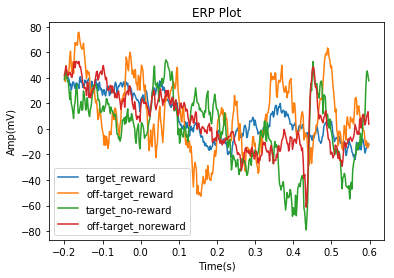

In [22]:
flag=False
erp1=plot_average(tar_re,fil=flag) # tar_reward
erp2=plot_average(offtar_re,fil=flag) # tar_noreward
erp3=plot_average(tar_nore,fil=flag) # offtar_reward
erp4=plot_average(offtar_nore,fil=flag) # offtar_noreward
plt.legend(('target_reward','off-target_reward','target_no-reward','off-target_noreward'))

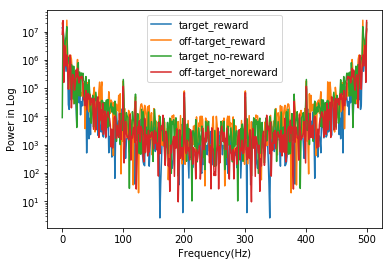

In [23]:
spec_plot(erp1)
spec_plot(erp2)
spec_plot(erp3)
spec_plot(erp4)
plt.legend(('target_reward','off-target_reward','target_no-reward','off-target_noreward'))

# Odd-even flip test

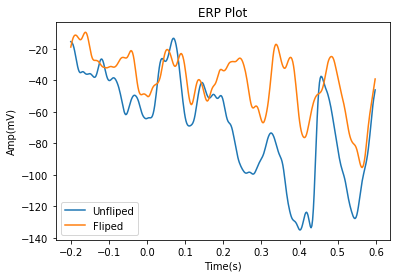

In [24]:
test=tar_nore
temp=copy.deepcopy(test)
temp[np.arange(0,temp.shape[0],2)]=-temp[np.arange(0,temp.shape[0],2)]
test=plot_average(test,fil=True)
test1=plot_average(temp,fil=True)
plt.legend(('Unfliped','Fliped'))

# Filtered

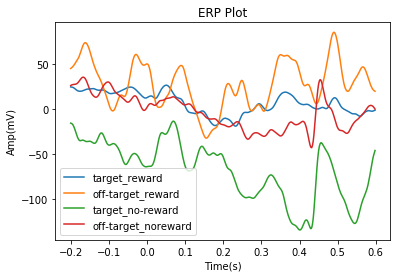

In [25]:
erp11=plot_average(tar_re,fil=True) # tar_reward
erp22=plot_average(offtar_re,fil=True) # tar_noreward
erp33=plot_average(tar_nore,fil=True) # offtar_reward
erp44=plot_average(offtar_nore,fil=True) # offtar_noreward
plt.legend(('target_reward','off-target_reward','target_no-reward','off-target_noreward'))

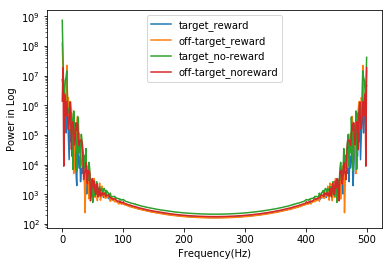

In [26]:
spec_plot(erp11)
spec_plot(erp22)
spec_plot(erp33)
spec_plot(erp44)
plt.legend(('target_reward','off-target_reward','target_no-reward','off-target_noreward'))

# Make Plots

In [9]:
rat_2_anal=sorted(list(set(dp.day1['subject'])))[1:] # droped 25 cuz it only had one recording
del rat_2_anal[6] # also dropping the seventh one cuz there's a bug where there's one less reward
days=2
behavior_log={}
behavior_df=pd.read_pickle(behavior_log_path+'rat26to38.pkl')

26
(4, 1371900)
(4, 1408110)
28
(4, 1458630)
(4, 1395660)
29


/home/AD/hop006/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


(4, 1453980)
(4, 1577820)
30
(4, 1343550)
(4, 1577820)
31
(4, 1867320)
(4, 1419330)
33
(4, 1418730)
(4, 1574130)
35
(4, 1622910)
(4, 1496370)
36
(4, 1490610)
(4, 1496370)
37
(4, 1507680)
(4, 1538760)
38
(4, 1885350)
(4, 1418010)


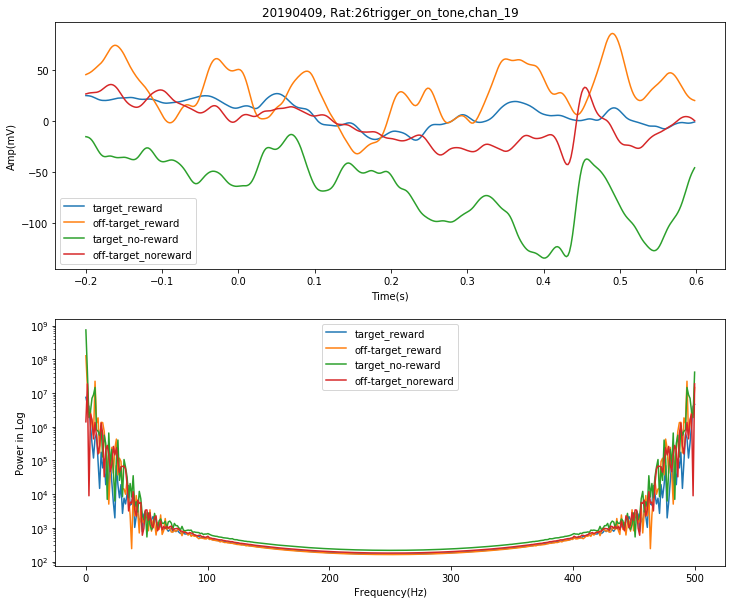

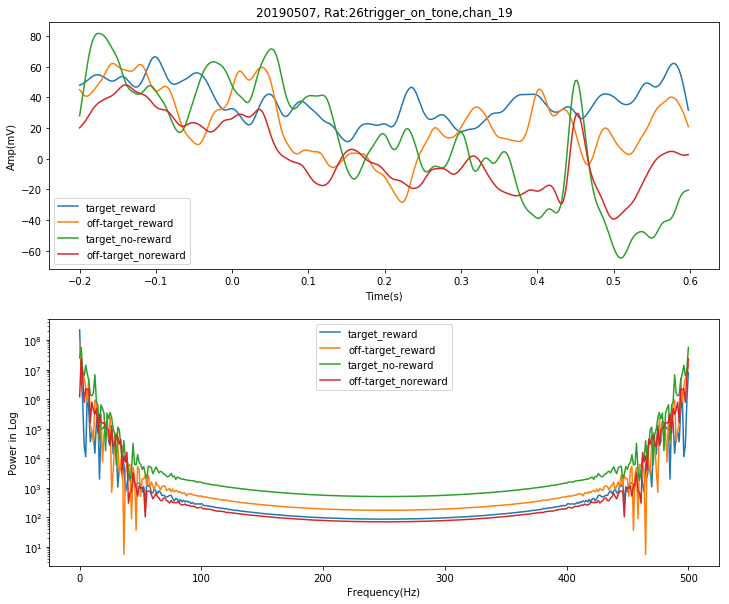

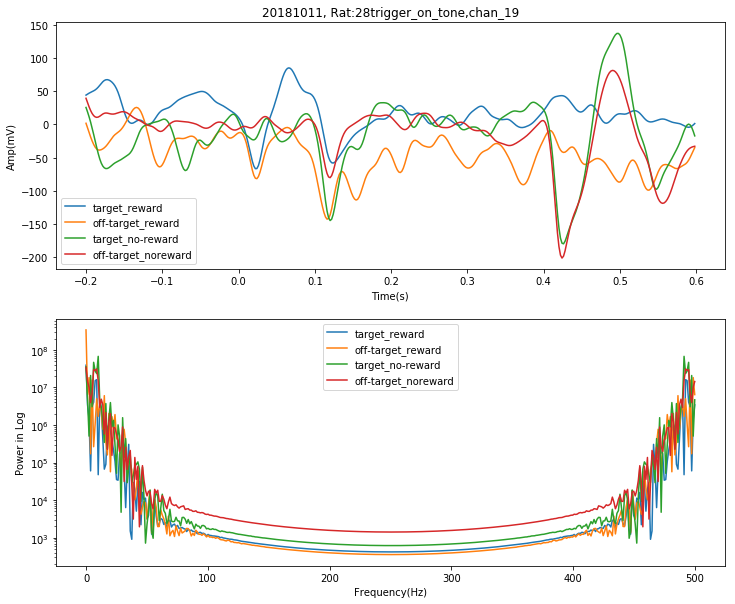

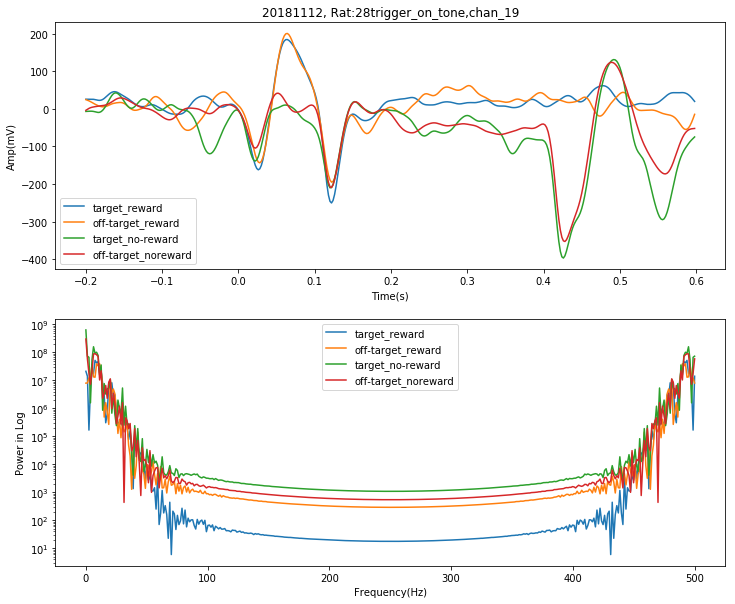

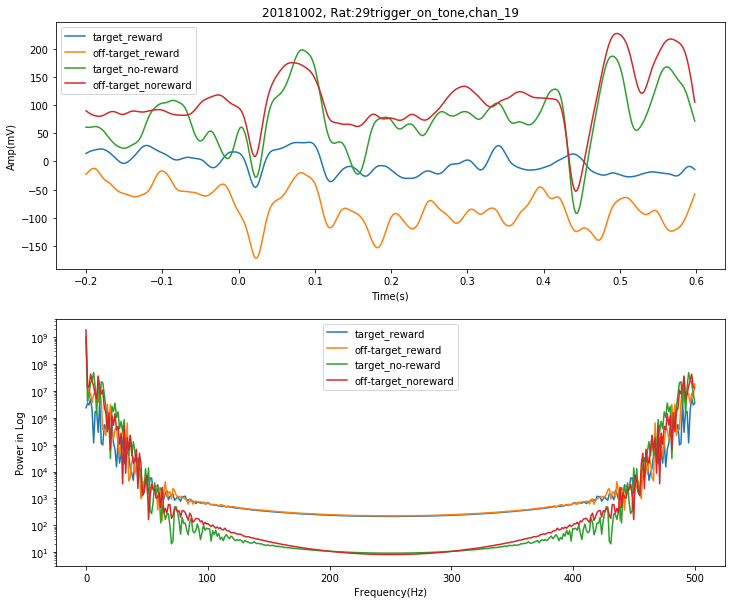

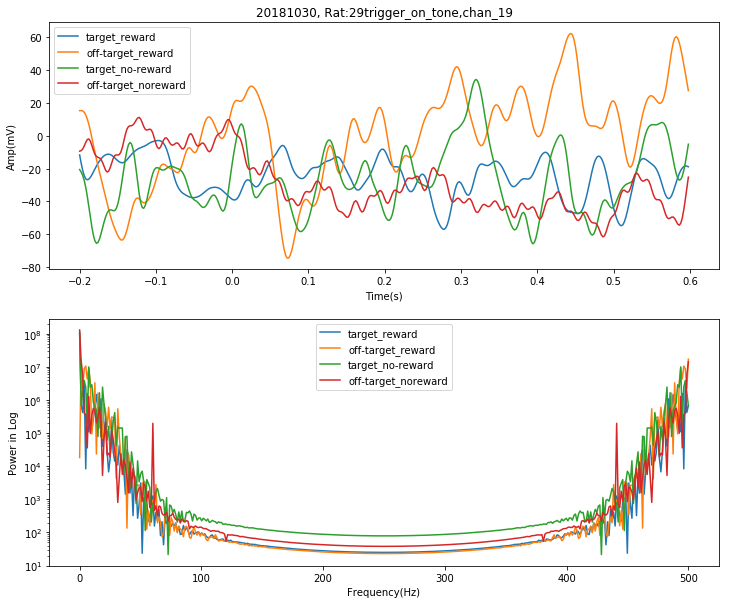

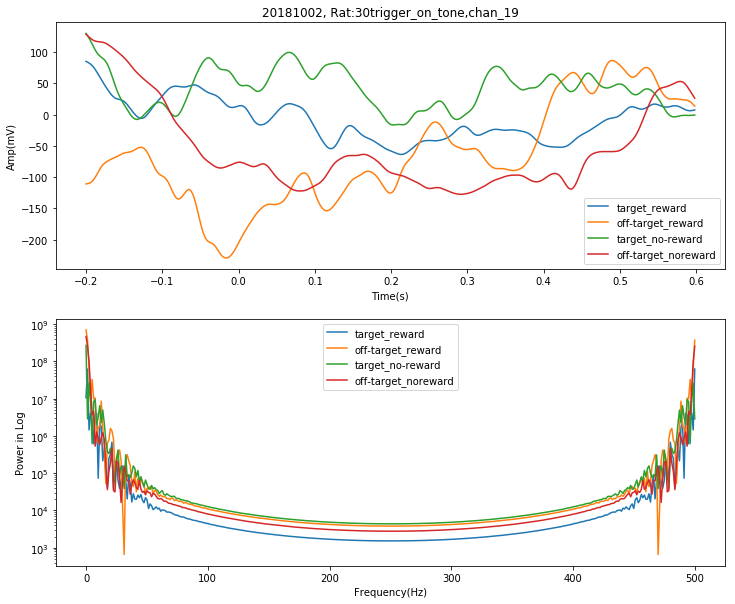

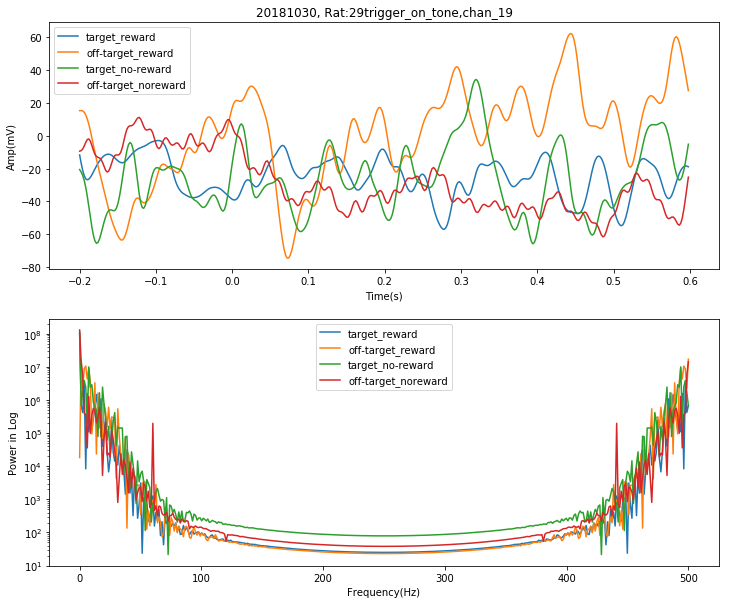

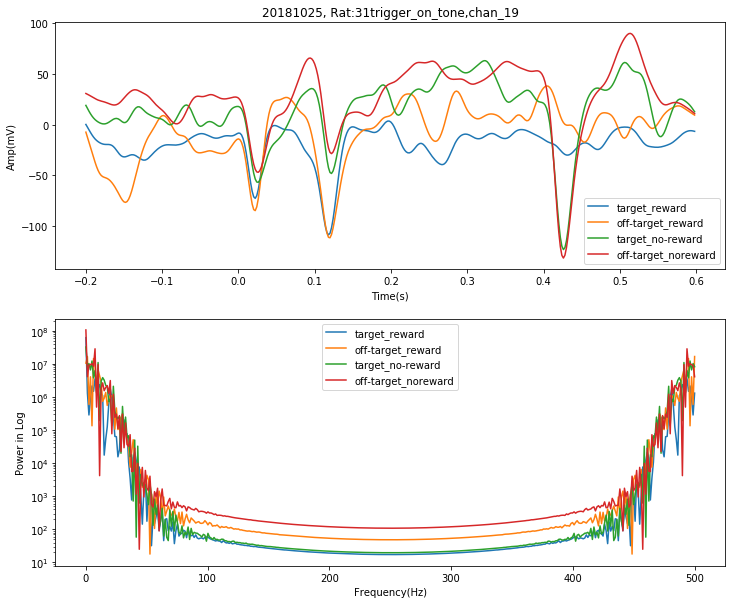

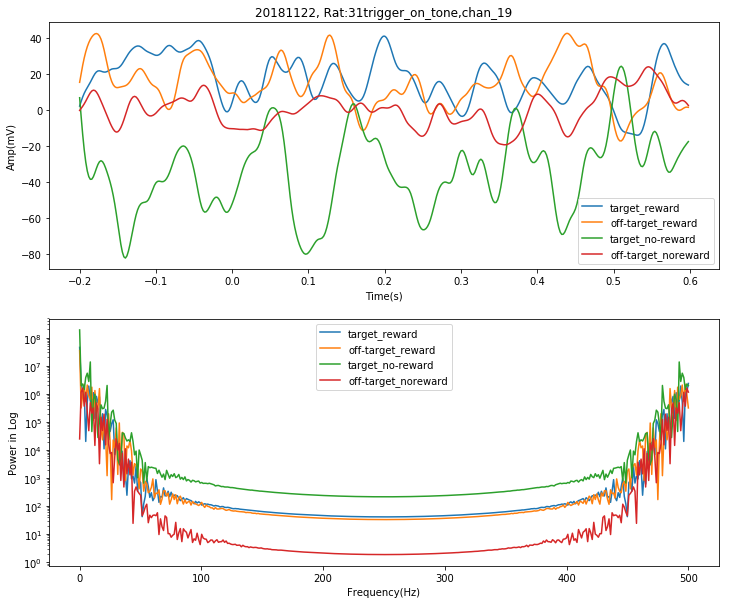

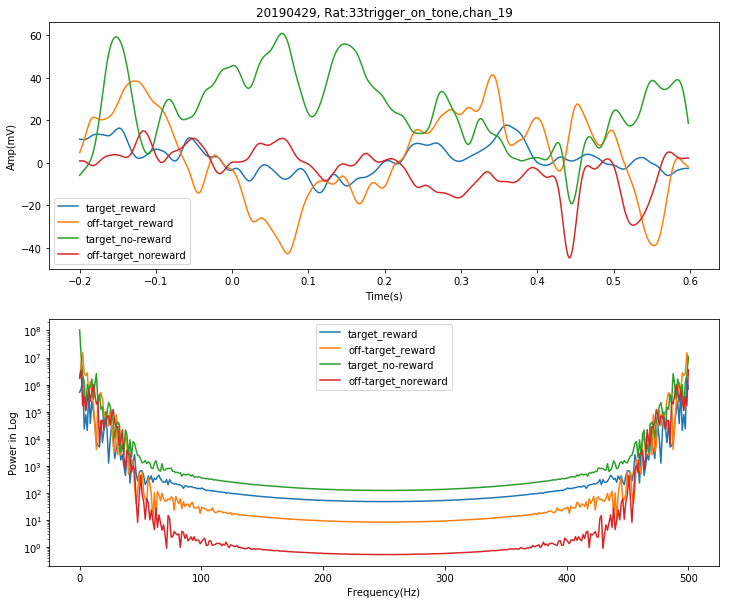

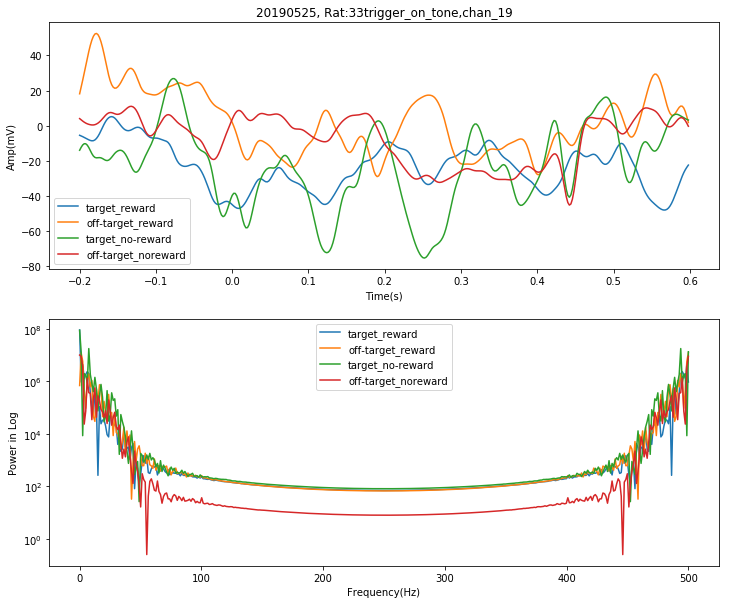

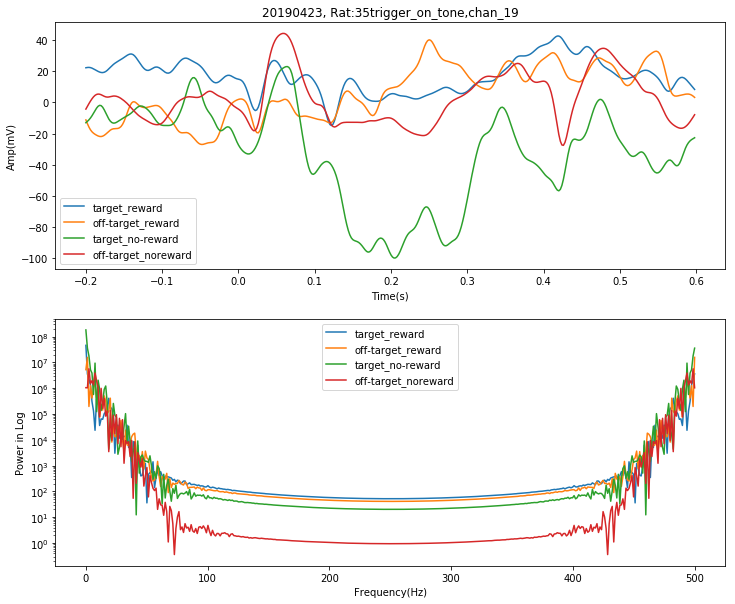

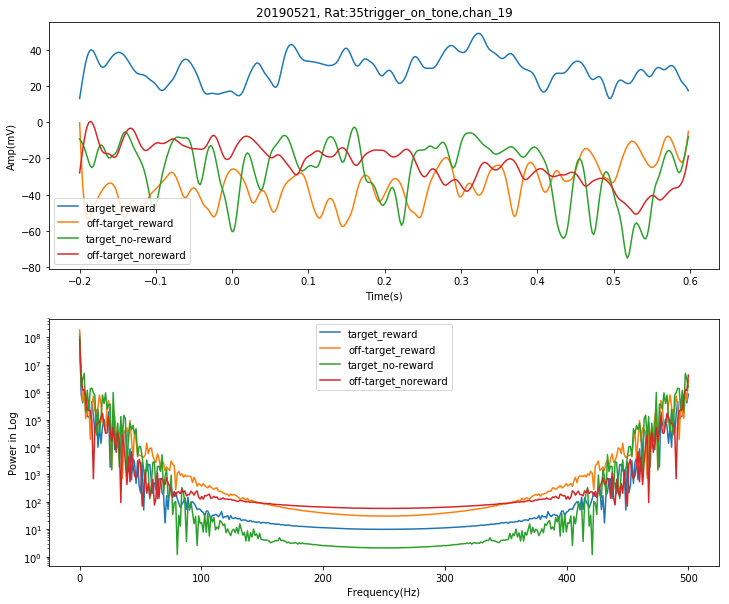

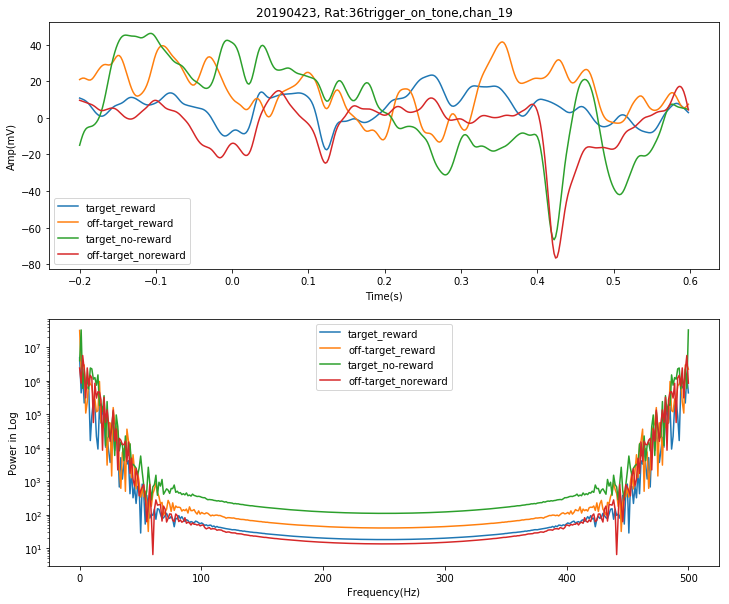

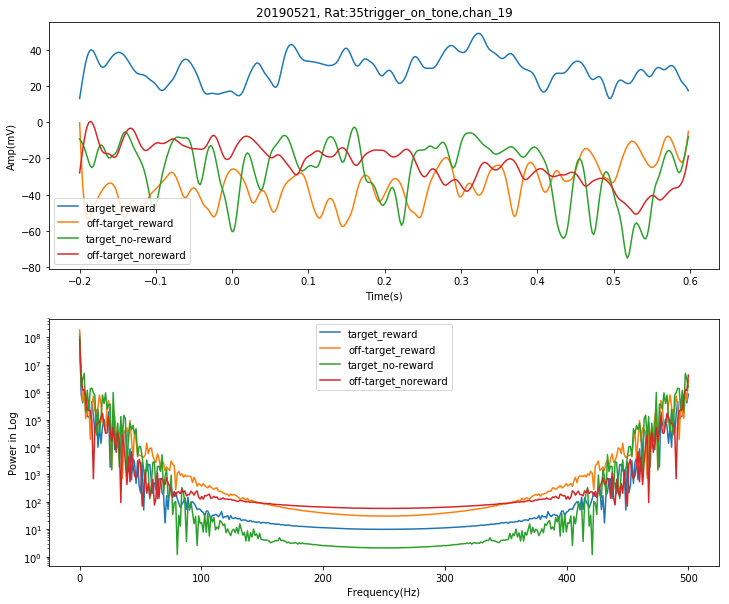

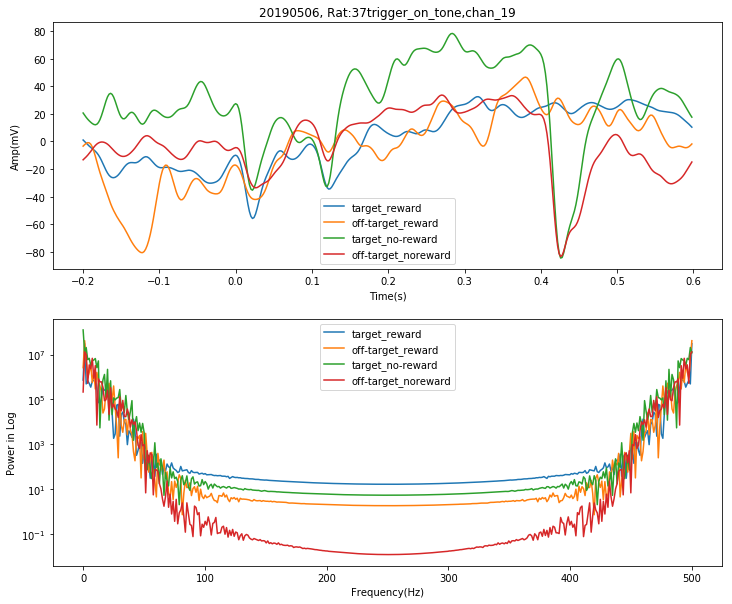

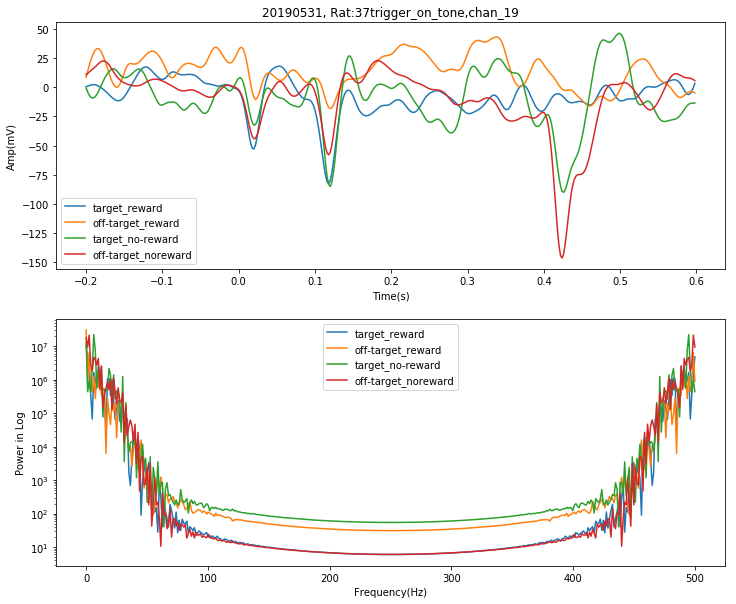

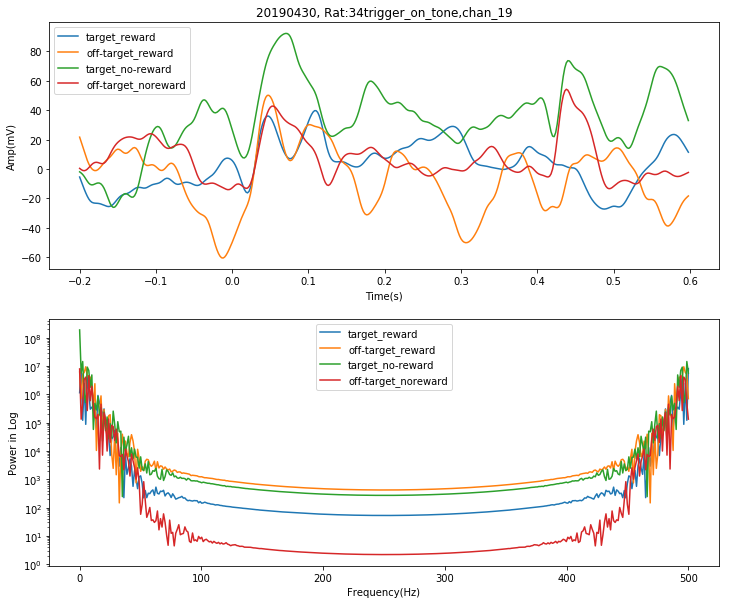

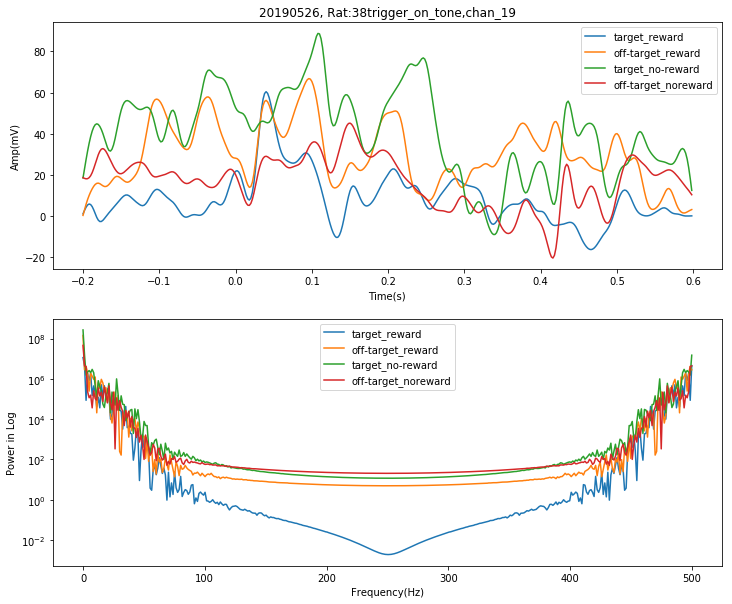

In [47]:
indx=np.array([])
count=1
for rat in rat_2_anal:
    print(rat)
    val_chan,chan_name,dates,rat_nums,reward_tone=get_excel_info(rat)
    for day in range(days):
        plt.figure(count,figsize=(12,10))
        count+=1
        plt.subplot(2,1,1)
        rat_df= get_ephys(dates[day],rat_nums[day])
        action_log,reward_log,epoched_eeg= get_behavior(rat_df,300,reward_tone,plot=False);
        tar_r= eeg_by_label(epoched_eeg,19,action_log,reward_log,1,1) # default channel 19
        off_r= eeg_by_label(epoched_eeg,19,action_log,reward_log,2,1)
        tar_n= eeg_by_label(epoched_eeg,19,action_log,reward_log,1,0)
        off_n= eeg_by_label(epoched_eeg,19,action_log,reward_log,2,0)
        erp1= plot_average(tar_r,fil=True) # specify filter range here
        erp2= plot_average(off_r,fil=True)
        erp3= plot_average(tar_n,fil=True)
        erp4= plot_average(off_n,fil=True)
        plt.title(str(dates[day])+', Rat:'+str(rat_nums[day])+'trigger_on_tone,chan_19')
        plt.legend(('target_reward','off-target_reward','target_no-reward','off-target_noreward'))
        plt.subplot(2,1,2)
        spec_plot(erp1)
        spec_plot(erp2)
        spec_plot(erp3)
        spec_plot(erp4)
        plt.legend(('target_reward','off-target_reward','target_no-reward','off-target_noreward'))
        plt.savefig(ERP_plot_path+str(rat_nums[day])+str(dates[day])+'_fil_EEGplots.png', bbox_inches='tight')

In [38]:
oldr=behavior_df[26]['reward'][0]
olda=behavior_df[26]['action'][0]
sum(olda==1)*0.8+0.2*sum(olda==2), sum(oldr)

(132.0, 132.0)

In [40]:
0.8*sum(action_log==1)+0.2*sum(action_log==2),sum(reward_log)

(162.0, 162.0)

In [43]:
162/294

0.5510204081632653